# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# set environment
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()
import seaborn as sns

# progress bar for jupyter notebook 
from tqdm import tqdm_notebook as tqdm 

# keep workspace running
from workspace_utils import active_session

# set dependencies
# basics
import numpy as np
import pandas as pd
import time
import os
import copy
import warnings
warnings.simplefilter('ignore')
from collections import OrderedDict

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# image processing
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

### Dependencies
This section includes also dependencies necessary for initializing two models __vgg__ and __resnet__ which I have selected for screening. Code can be extended for other models. It is necessary to include dependences here, as some of the models use diffrent size of the inputs where image processing / transforms are dependent on. 

Section includes following class and methods:
- `Fc_Network` class: builds fully connected classifier for transfer learning
- `freeze_model_params` method: freeze model parameters for feature extraction type of transfer learning
- `initialize_model method`: initialize selected model for transfer learning
- `NormalizeInverse` class: invert normalization of image tensor
- `explore_images` method: show arbitrary number of images with labels

Code was adapted using following resources: 
- [Udacity: Deep learning with PyTorch](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/fc_model.py)
- [PyTorch: Transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [PyTorch: Finetuning Torchvision models](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
- [Josh Bernhard: Deep Learning with PyTorch](https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad)

In [2]:
class FcNetwork(nn.Module):
    '''
    Builds a feedforward network with arbitrary hidden layers
    with ReLU activation function and drop out

    Note: Forward method returns logits (raw outputs)

    Args:
        input_size: integer, size of the input layer
        output_size: integer, size of the output layer
        hidden_layers: list of integers, the sizes of the hidden layers
    '''
    def __init__(self, input_size, output_size, hidden_layers=None, drop_p=0.5):

        super().__init__()

        # drop out probability attribute

        # if hidden leayers are not requested
        if (hidden_layers == None) or (hidden_layers == []):
            self.drop_p = None
            self.hidden_layers = None
            self.output = nn.Linear(input_size, output_size)
        else:
            # hidden layers requested
            # attribute drop out probability
            self.drop_p = drop_p

            # 1st hidden layer
            self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])

            # add a variable number of  more hidden layers
            layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
            self.hidden_layers.extend([nn.Linear(in_features, out_features)
                                      for in_features, out_features in layer_sizes])

            # regularization
            self.dropout = nn.Dropout(p=self.drop_p)

            # output of the network
            self.output = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x):
        '''
        Forward pass trough network ,returns the ouput logits (raw outputs)
        '''
        # forward input trough hidden layers if they exists
        if not (self.hidden_layers == None):
            for layer in self.hidden_layers:
                x = layer(x)
                x = F.relu(x)
                x = self.dropout(x)

        # forward input trough last layer
        output = self.output(x)

        return output

    def layer_sizes(self):
        '''
        Returns model architecture as list of layer sizes in string format.
        Example of layer with 25k inputs, 2048 nodes of 1st hidden layer,
        1024 of sencond, 512 of third and 102 outputs is equal to string
        [25000, 2048, 1024, 512, 102]

        Returns:
            architecture: string as list of neural network layer layer_sizes
        '''

        layer_sizes = []
        #  no hidden layers defined
        if self.hidden_layers == None:
            # gent # of inputs to output layer
            layer_sizes.append(self.output.in_features)
        #  hidden leayers defined
        else:
            # inputs to first hidden layer
            layer_sizes.append(self.hidden_layers[0].in_features)
            # cycle over hidden layers
            for hidden_layer in self.hidden_layers:
                # get hidden layer nodes
                layer_sizes.append(hidden_layer.out_features)

        # add # of outputs | classes | nodes of output layer
        layer_sizes.append(self.output.out_features)

        return str(layer_sizes)

In [3]:
def freeze_model_params(model, feature_extract=True):
    '''
    Freeze model parameters for feature extraction type of transfer learning
    
    Args:
        model: neural network model of nn.Module class or its child
        feature_extract: transfer learning type feature extraction ro
                         tunning, deafult: feature_extract=True
    '''
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

In [4]:
def initialize_model(model_name, num_classes, feature_extract=True, 
                     pretrained=True, hidden_layers=None, drop_p=0.2, model_id=None, class_to_idx=None):
    '''
    Initialize selected model for transfer learning
    
    note: following list of models is supported [vgg, resnet] 
          and can be further extended
    
    Args:
        model_name: name of the model
        num_classes: number of classes in the output of designed network
        
        feature_extract: transfer learning type feature extraction or
                         tunning, default: feature_extract=True
                         
        pretrained: network weight initialization: pretrained or 
                    not pretrained, dafault: use_pretrained=True
                    
        hidden_layers: classifier architecture need to be fully connected network (n+2 layers)
                              with drop out, defined as list of sizes of hidden layers:
                              [num_hidden_layer_1, num_hidden_layer_2, ..., num_hidden_layer_n]
                              example: [2048, 1024, 512]
                              
                              Note: input layer is defined by model name and output by num_classes
        
        drop_p: drop out probability
        
    Returns:
        model: model adapted for transfer learning with initialized weights
        input_size: required input_size of the model
    '''
    
    # initialize returns
    model = None
    input_size = 0
    if model_id == None: model_id = model_name
    
    if 'vgg' in model_name:
        # initialize model
        model = models.vgg11_bn(pretrained=pretrained)

        # freeze model parameters in case of transfer learning type: feature extraction
        freeze_model_params(model, feature_extract)

        # get number of input nodes of the classifier laeyer to replace
        in_features = model.classifier[0].in_features
        
        # rebuild model and remove last layer of the classifier
        model.classifier = FcNetwork(in_features, num_classes, hidden_layers, drop_p=drop_p)
         
        # create attribute model name & id
        model.name = model_name
        model.id = model_id
        
        # create attribute storking mappings of class codes to indexes
        model.class_to_idx = class_to_idx
        
        # define number of inputs the model was trained on
        input_size = 224
    
    elif 'resnet' in model_name:
        model = models.resnet50(pretrained=pretrained)
        freeze_model_params(model, feature_extract) 
        in_features = model.fc.in_features
        model.fc = FcNetwork(in_features, num_classes, hidden_layers, drop_p=drop_p)
        model.name = model_name
        model.id = model_id
        model.class_to_idx = class_to_idx
        input_size = 224
    
    else:
        print('Invalid model name.')
    
    return model, input_size

In [5]:
class NormalizeInverse(transforms.Normalize):
    """Reconstruct the normalized image by inverting normalization which was
    given by mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels.
    This transform will invert each normalized channel of the input ``torch.*Tensor``
    created by normalize transformation as ex. below:
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``

    .. note::
        This transform acts out of place, i.e., it does not mutates the input tensor.

    Args:
        transform: instance of transform used to normalize image tensor
    """

    def __init__(self, transform):
        assert isinstance(transform, transforms.Normalize), \
        'transform need to be torchvision.transfroms.transforms.Normalize object'
        mean = torch.tensor(transform.mean)
        std = torch.tensor(transform.std)
        std_inv = (1 / (std + 1e-7))
        mean_inv = (-mean * std_inv)

        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Normalized Tensor image of size (C, H, W) to be inverted.

        Returns:
            Tensor: Reconstructed Tensor image.
        """
        return super().__call__(tensor)

In [6]:
def explore_images(image, transform, title=None):
    '''
    Print reconstructed normalized images

    Args:
        image: Normalized tensor image of size (C, H, W)
        transform - instance of transformation used to normalize image
    '''

    # reconstruct image
    normalize_inv = NormalizeInverse(transform)
    image = normalize_inv(image)

    # transpose image from (C,L,W) to (L,W,C) and clip it for float RGB values <0,1>
    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)

    # print image
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

### Initializing network architectures for screening

In [7]:
# INTIALIZE NETWORK ARCHITECTURES
# select models
net_names = ['vgg19_bn', 'resnet50']

# number of classes
num_classes = 102

# type of transfer learning: feature extraction or tunning
feature_extract = True

# architecture of new classifier: just hidden layers sizes in the list
hidden_layers = []

# initialization of weights of the model: pre-trained or random
pretrained = True

# drop out probability
drop_p = 0.5

# initialize selected models for transfer learning
nets = {net_name: initialize_model(net_name, num_classes, feature_extract, 
                                     pretrained, hidden_layers, drop_p)
         for net_name in net_names}

# input size to determine image preprocessing
input_sizes = {net: nets[net][1] for net in nets}
nets = {net: nets[net][0] for net in nets}

### Image processing

In [8]:
# IMAGE PROCESSING
# datasets phases
phases = ['train', 'valid', 'test']

# data directories
data_dir = 'flowers'

# batch size for training
batch_size = 32

# image standardization
avgs, stdevs = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# image resize
resize = 256

# image rotation
rot = 30

# input size
# image processing for the training, validation, and testing for all models
data_transforms = {net: {
    phases[0]: transforms.Compose([
        transforms.RandomRotation(rot),
        transforms.RandomResizedCrop(input_sizes[net]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(avgs, stdevs)
    ]),
    phases[1]: transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(input_sizes[net]),
        transforms.ToTensor(),
        transforms.Normalize(avgs, stdevs)
    ]),
    phases[2]: transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(input_sizes[net]),
        transforms.ToTensor(),
        transforms.Normalize(avgs, stdevs)
    ])}
                   for net in nets
                  }

# load the datasets with ImageFolder
image_datasets = {net: {
    phase: datasets.ImageFolder(
        os.path.join(data_dir, phase),data_transforms[net][phase]) 
    for phase in phases}
                  for net in nets
                 }

# define the dataloaders
dataloaders = {net: {
    phase: torch.utils.data.DataLoader(
        image_datasets[net][phase], batch_size=batch_size, shuffle=True)
    for phase in phases}
               for net in nets
              }

# explore datasets sizes
dataset_sizes = {net: {
    phase: len(image_datasets[net][phase]) for phase in phases}
                 for net in nets
                }

### Exploring Data

#### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json module`](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
import json

with open('cat_to_name.json', 'r') as f:
    class_to_name = json.load(f)

{'vgg19_bn': {'train': 6552, 'valid': 818, 'test': 819}, 'resnet50': {'train': 6552, 'valid': 818, 'test': 819}}


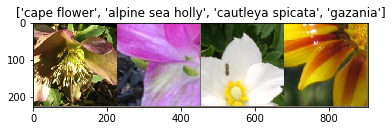

In [10]:
# EXPLORING DATA
# Data shape
print(dataset_sizes)

# explore dataset images
# get a batch of training images
images, categories = next(iter(dataloaders[net_names[0]][phases[0]]))

# Make a grid of first n_images selected images in batch
n_images = 4
image_grid = torchvision.utils.make_grid(images[:n_images, :])

# denormalize and print images
explore_images(image_grid, transform=data_transforms[net_names[0]][phases[0]].transforms[-1],
      title=[class_to_name[str(category)] for category in categories[:n_images].tolist()])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

### Dependencies
This section includes also `save_model` method as it is needed to store model inmediately after trainin is finished in active session context manager to prevent lossing training data.

Dependencies icludes following methods
- `trian_model` method: trains neural network model
- `params_to_update` method: returns generator of parameters to update during learning
- `save_model` method: saves naural network model

In [11]:
def train_model(model, dataloaders, criterion, optimizer, phases=['train', 'valid'], 
                scheduler=None, num_epochs=15, batch_ratio=1):
    '''
    Train neural network with arbitrary architecture, loss function, optimization algorithm, 
    adaptive learning rate and returns model with best accuracy
    
    Args:
        model: model with arbitrary architecture of torch.nn module
        dataloaders: dictionary of data loaders per learning phase,
                     dataloader interates in batches trough data in each phase
        criterion: loss fuction of torch.nn module
        optimizer: optimization algorithm of torch.optim module
        phases: list of learning phases one or some of ['train', 'valid']
        sheduler: adpative learning rate sheduler of torch.optim module
        num_epochs: number of epochs to train model on, default is 15
        batch_ratio: iterates over bath_ration % of batches in dataset
        
    Returns:
        model with updated weights corresponding to highest accuracy
    '''

    # debugging on batch results will be printed
    debug_mode = False
    
    # frequency of printing results every x batch
    print_every = 1
    
    # track training time
    since = time.time()
    
    # track model settings and performance of each epoch
    # list of setting and performance items
    items = ['model_id', 'model', 'modification', 'learning rate', 'epoch', 'phase', 'acc', 'loss', 'time']
    
    # number of performance items 
    num_results = 3
    
    # create empty multi-column data frame to track history
    col_hierarchy = pd.MultiIndex.from_tuples(
        [('settings' if time_idx < (len(items) - num_results) else 'performance', item)
         for time_idx, item in enumerate(items)])
    
    history = pd.DataFrame(columns=col_hierarchy)
    
    # store best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initiate accuracy tracking
    best_acc = 0.0
    
    # print model name
    print_model = 'model: {} ---> id: {}'.format(model.name, model.id)
    print(print_model)
    print('*' * len(print_model))
    
    # model training and validation
    for epoch in tqdm(range(num_epochs)):
        # track epoch running time
        epoch_since = time.time()

        # notify user on running epoch
        print_epoch = 'epoch {}/{}'.format(epoch + 1, num_epochs)
        print(print_epoch)
        print('-' * len(print_epoch))

        # Cycles trough epoch training and validation phase
        for phase in phases:
            # monitor phase time
            phase_since = time.time()
            
            if phase == 'train':
                # update learning rate if using sheduler
                if not (scheduler == None):
                    scheduler.step()
                model.train()    # set model in training mode              
            else:
                model.eval()    # set model in evaluation mode

            # reset loss, corrects and running time from previous epoch
            running_loss = 0.0
            running_corrects = 0
            running_time = 0
            
            # reset running number of samples 
            running_size = 0

            # iterate over n batches in dataset
            num_batches = max(1, int(len(dataloaders[phase]) * batch_ratio))
            for batch, (inputs, labels) in zip(range(num_batches), dataloaders[phase]):
                
                # trace batch time in debug mode
                if debug_mode: batch_since = time.time()
                    
                # update number of samples
                # import ipdb; ipdb.set_trace()
                running_size += inputs.size(0)
                
                # transfer data to gpu if enabled
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients from previous batch
                optimizer.zero_grad()

                # track operations on model parameters to calculate gradient 
                # only for training phase
                with torch.set_grad_enabled(phase == 'train'):
                    # calculate model output
                    outputs = model(inputs)

                    # calculate loss
                    loss = criterion(outputs, labels)

                    # calculate top k prediction
                    _, preds = outputs.topk(1, dim=1)

                    # backward step, calculate and update weights in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # accumulate loss, number of correct clasifications and running time 
                # in batch and phase
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.view(preds.shape))
                
                # with debug on, print batch results
                if debug_mode and (phase == 'train') and ((batch + 1) % print_every == 0) :
                    # calculate batch time
                    batch_time = time.time() - batch_since
                    
                    # calculate average running batch loss and accuracy for phase
                    batch_loss = loss.item()
                    batch_acc = torch.sum(preds == labels.view(preds.shape)).double() / inputs.size(0)
                    
                    # print batch results per phase
                    print('{} batch {:3}/{:3} loss: {:.4f} Acc: {:.4f} Time:{:.0f}s'
                         .format(phase, batch+1, len(dataloaders[phase]),
                                batch_loss, batch_acc, batch_time))

            # calculate epoch loss and accuracy for phase
            epoch_phase_loss = running_loss / running_size
            epoch_phase_acc = (running_corrects.double() / running_size).item()
            epoch_phase_time = time.time() - phase_since


            # print epoch results per phase
            print('{} loss: {:.4f} acc: {:.4f} time: {:.0f}m {:.0f}s'
                  .format(phase, epoch_phase_loss, epoch_phase_acc,
                         epoch_phase_time // 60, epoch_phase_time % 60))

            # store model settings and epoch performance
            # learning rate
            if scheduler == None : 
                lr = optimizer.param_groups[0]['lr']
            else: 
                lr = str(type(scheduler)).split('.')[-1].rstrip("'>")
            
            # consolidate settings & performance
            epoch_phase_result = [model.id, model.name, list(model.children())[-1].layer_sizes(), lr,
                                  int(epoch+1), phase, epoch_phase_acc, epoch_phase_loss, epoch_phase_time]
            epoch_phase_result = pd.DataFrame([epoch_phase_result], columns = col_hierarchy)
            
            # append settings & epoch results to dataframe
            history = history.append(epoch_phase_result, ignore_index=True)

            # store weights if validation accuracy is best
            if phase == 'valid' and epoch_phase_acc > best_acc:
                best_acc = epoch_phase_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # ad space after epoch results
        print()
        
    # record and print training time
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))        
        
    # print best validation accuracy  
    print('Best val Acc: {:.4f}'.format(best_acc))
    print('\n\n')
    return model, history

In [12]:
def params_to_update(model_params):
    '''
    Returns model parameters which will be tuned during training
    
    Arg:
        model_params: neural network model parameters as generator
                      Note: use nn.Module.parameters()
    Returns: 
        generator of parameters to be updated during training
    '''
    
    for param in model_params:
        if param.requires_grad == True:
            yield param

In [13]:
def save_model(model, optimizer=None, scheduler=None, train_history=None, path='checkpoint.pth'):
    '''
    Save pytorch model for inference and/or resuming training. 

    Args:
        model: any instance of pytorch.models where last layer is adapted
               using FcNetwork class

        optimizer: any optimization algorithm of pytorch.optim class,
                   use only for resuming training purpose, default None
        sheduler: any learning rate sheduler nn.optim.lr_sheduler class
                  us enly for resuming training purpose if it was used, 
                  defulat None
        train_history: any other training history it need to be saved
        path: path and file name, default 'checkpoint.pth'

    Returns:
        saved model file on defined path location               
    '''
    # reference to classifier (last) module of the model
    classifier = list(model.children())[-1]
    
    # save best model
    torch.save({'model':
                {'id': model.id,
                 'name': model.name,
                 'num_classes': classifier.output.out_features,
                 'feature_extract': ~np.all([param.requires_grad for param in model.parameters()]),
                 'hidden_layers': None if classifier.hidden_layers == None else
                                  [layer.out_features for layer in classifier.hidden_layers],
                 'dropout_prob': classifier.drop_p,
                 'state_dict': model.state_dict(),
                 'class_to_idx': model.class_to_idx
                },
                'optimizer': None if optimizer == None else{
                    'state_dict': optimizer.state_dict()},
                'lr_scheduler': None if scheduler == None else {
                    'step_size': scheduler.step_size,
                    'state_dict': scheduler.state_dict()},
                'train_history': train_history
               },
               path
              )

### Screening neural network models
I have decided to screen two models `vgg19_bn` and `resnet50` as feature extractors and modify their classifier to flower classification problem of 102 classes. Training is done on 30% of training and validation data to save time and resources. The full scale training and hyper-parameter tuning will be done on selected screened model.

In [14]:
# use gpu for training if enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# MODEL SCREENING
# ----------------

# TRAINING PRERQUISITES
# number of epochs
num_epochs = 10

# define start learning rate
start_lr = 0.001

# define loss fuction
criterion = nn.CrossEntropyLoss()

# get learning parameters and define optimization algorithm
optimizers = {net: optim.Adam(params_to_update(nets[net].parameters()), lr=start_lr)
              for net in nets}

# learning rate adaptation
lr_adapt = False     # flag to turn on flexible lr
end_lr = 0.00001     # learning rate of last epoch
step_size = 1        # nummber of epochs to decay learning rate by gamma

# lr decay parameter end_lr = start_lr*gamma**(epochs/step_size)
gamma = (end_lr / start_lr) ** (step_size / num_epochs)    

# initialize shedulers
lr_schedulers = {
    net: lr_scheduler.StepLR(optimizers[net], step_size=1, gamma=gamma) if lr_adapt else None
    for net in nets}

# train all models on x % of data
batch_ratio = 0.3    # 30% of data

# move the networks to gpu if enabled
for net in nets:
    net = nets[net].to(device)

In [16]:
# RUN TRAINING
# keep workspace active
with active_session():
    trained_nets = {net: train_model(model=nets[net], dataloaders = dataloaders[net], 
                                            criterion=criterion, optimizer=optimizers[net], 
                                            scheduler=lr_schedulers[net], num_epochs=num_epochs, batch_ratio = batch_ratio)
                    for net in nets}

    # extract training output
    # models
    nets = {net: trained_nets[net][0] for net in nets}

    # training history
    hists = {net: trained_nets[net][1] for net in nets}
    results = pd.DataFrame([])

    # merge models training history
    for hist in hists:
        results = results.append(hists[hist], ignore_index=True)

    # SAVE SELECTED SCREENED MODEL
    # select best model after screening
    # indentify index of model with highest validation accuracy
    best_scr_model_idx = results[results[('settings', 'phase')] == 'valid'][('performance', 'acc')].idxmax()
    best_scr_model_name = results.iloc[best_scr_model_idx][('settings', 'model')]
    best_scr_model = nets[best_scr_model_name]

    # save model
    path = 'checkpoint_ipynb.pth'
    save_model(best_scr_model, optimizers[best_scr_model_name], 
               lr_schedulers[best_scr_model_name], hists[best_scr_model_name], path=path)

    print('Model: {} with id: {} saved to {}.'
          .format(best_scr_model.name, best_scr_model.id, path))

model: vgg19_bn ---> id: vgg19_bn
*********************************


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

epoch 1/10
----------
train loss: 3.2125 acc: 0.3443 time: 0m 35s
valid loss: 1.3359 acc: 0.7009 time: 0m 4s

epoch 2/10
----------
train loss: 1.4347 acc: 0.6455 time: 0m 34s
valid loss: 0.6799 acc: 0.7946 time: 0m 4s

epoch 3/10
----------
train loss: 1.1291 acc: 0.7100 time: 0m 34s
valid loss: 0.5638 acc: 0.8393 time: 0m 4s

epoch 4/10
----------
train loss: 0.8856 acc: 0.7700 time: 0m 33s
valid loss: 0.6005 acc: 0.8616 time: 0m 4s

epoch 5/10
----------
train loss: 0.7893 acc: 0.7869 time: 0m 33s
valid loss: 0.3423 acc: 0.8929 time: 0m 4s

epoch 6/10
----------
train loss: 0.8243 acc: 0.7889 time: 0m 32s
valid loss: 0.5340 acc: 0.8750 time: 0m 4s

epoch 7/10
----------
train loss: 0.8189 acc: 0.7894 time: 0m 32s
valid loss: 0.4094 acc: 0.8750 time: 0m 4s

epoch 8/10
----------
train loss: 0.7085 acc: 0.8186 time: 0m 32s
valid loss: 0.5593 acc: 0.8839 time: 0m 4s

epoch 9/10
----------
train loss: 0.6532 acc: 0.8330 time: 0m 32s
valid loss: 0.3512 acc: 0.8839 time: 0m 4s

epoch 10/1

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

epoch 1/10
----------
train loss: 3.9693 acc: 0.2264 time: 0m 32s
valid loss: 2.4442 acc: 0.5848 time: 0m 4s

epoch 2/10
----------
train loss: 2.3110 acc: 0.5528 time: 0m 32s
valid loss: 1.4527 acc: 0.7232 time: 0m 4s

epoch 3/10
----------
train loss: 1.5911 acc: 0.6885 time: 0m 32s
valid loss: 1.0011 acc: 0.8036 time: 0m 4s

epoch 4/10
----------
train loss: 1.2376 acc: 0.7572 time: 0m 32s
valid loss: 0.7555 acc: 0.8348 time: 0m 4s

epoch 5/10
----------
train loss: 1.0138 acc: 0.7910 time: 0m 32s
valid loss: 0.7040 acc: 0.8259 time: 0m 4s

epoch 6/10
----------
train loss: 0.9312 acc: 0.7869 time: 0m 33s
valid loss: 0.5364 acc: 0.8884 time: 0m 4s

epoch 7/10
----------
train loss: 0.8188 acc: 0.8258 time: 0m 33s
valid loss: 0.4823 acc: 0.8973 time: 0m 4s

epoch 8/10
----------
train loss: 0.7738 acc: 0.8274 time: 0m 33s
valid loss: 0.4943 acc: 0.8750 time: 0m 4s

epoch 9/10
----------
train loss: 0.7128 acc: 0.8289 time: 0m 33s
valid loss: 0.4328 acc: 0.8839 time: 0m 4s

epoch 10/1

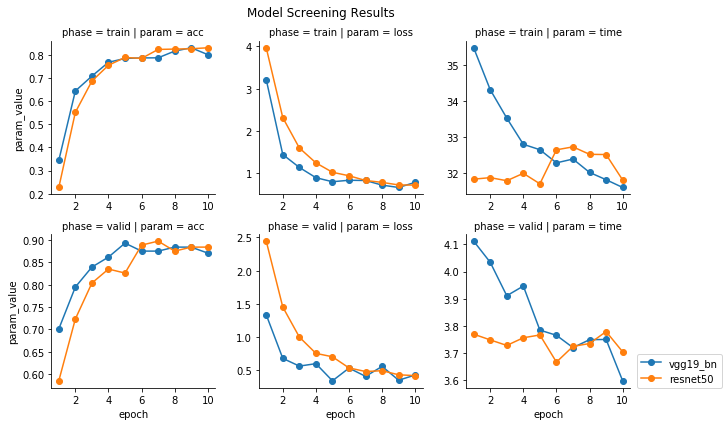

settings                                                    performance  \
    model_id     model  modification learning rate epoch  phase         acc   
33  resnet50  resnet50   [2048, 102]         0.001     7  valid    0.897321   
9   vgg19_bn  vgg19_bn  [25088, 102]         0.001     5  valid    0.892857   
31  resnet50  resnet50   [2048, 102]         0.001     6  valid    0.888393   
15  vgg19_bn  vgg19_bn  [25088, 102]         0.001     8  valid    0.883929   
17  vgg19_bn  vgg19_bn  [25088, 102]         0.001     9  valid    0.883929   
37  resnet50  resnet50   [2048, 102]         0.001     9  valid    0.883929   
39  resnet50  resnet50   [2048, 102]         0.001    10  valid    0.883929   
11  vgg19_bn  vgg19_bn  [25088, 102]         0.001     6  valid    0.875000   
13  vgg19_bn  vgg19_bn  [25088, 102]         0.001     7  valid    0.875000   
35  resnet50  resnet50   [2048, 102]         0.001     8  valid    0.875000   
19  vgg19_bn  vgg19_bn  [25088, 102]         0.001    10  valid    0.870536   
7   vgg19_bn  vgg19_bn  [25088, 102]         0.001     4  valid    0.861607   
5   vgg19_bn  vgg19_bn  [25088, 102]         0.001     3  valid    0.839286   
27  resnet50  resnet50   [2048, 102]         0.001     4  valid    0.834821   
29  resnet50  resnet50   [2048, 102]         0.001     5  valid    0.825893   
25  resnet50  resnet50   [2048, 102]         0.001     3  valid    0.803571   
3   vgg19_bn  vgg19_bn  [25088, 102]         0.001     2  valid    0.794643   
23  resnet50  resnet50   [2048, 102]         0.001     2  valid    0.723214   
1   vgg19_bn  vgg19_bn  [25088, 102]         0.001     1  valid    0.700893   
21  resnet50  resnet50   [2048, 102]         0.001     1  valid    0.584821   
16  vgg19_bn  vgg19_bn  [25088, 102]         0.001     9  train    0.832992   
38  resnet50  resnet50   [2048, 102]         0.001    10  train    0.832992   
36  resnet50  resnet50   [2048, 102]         0.001     9  train    0.828893   
34  resnet50  resnet50   [2048, 102]         0.001     8  train    0.827357   
32  resnet50  resnet50   [2048, 102]         0.001     7  train    0.825820   
14  vgg19_bn  vgg19_bn  [25088, 102]         0.001     8  train    0.818648   
18  vgg19_bn  vgg19_bn  [25088, 102]         0.001    10  train    0.803279   
28  resnet50  resnet50   [2048, 102]         0.001     5  train    0.790984   
12  vgg19_bn  vgg19_bn  [25088, 102]         0.001     7  train    0.789447   
10  vgg19_bn  vgg19_bn  [25088, 102]         0.001     6  train    0.788934   
8   vgg19_bn  vgg19_bn  [25088, 102]         0.001     5  train    0.786885   
30  resnet50  resnet50   [2048, 102]         0.001     6  train    0.786885   
6   vgg19_bn  vgg19_bn  [25088, 102]         0.001     4  train    0.769980   
26  resnet50  resnet50   [2048, 102]         0.001     4  train    0.757172   
4   vgg19_bn  vgg19_bn  [25088, 102]         0.001     3  train    0.710041   
24  resnet50  resnet50   [2048, 102]         0.001     3  train    0.688525   
2   vgg19_bn  vgg19_bn  [25088, 102]         0.001     2  train    0.645492   
22  resnet50  resnet50   [2048, 102]         0.001     2  train    0.552766   
0   vgg19_bn  vgg19_bn  [25088, 102]         0.001     1  train    0.344262   
20  resnet50  resnet50   [2048, 102]         0.001     1  train    0.226434   

                         
        loss       time  
33  0.482325   3.723569  
9   0.342283   3.783678  
31  0.536432   3.665525  
15  0.559298   3.748363  
17  0.351197   3.749164  
37  0.432817   3.778286  
39  0.420413   3.703529  
11  0.534018   3.764481  
13  0.409373   3.719020  
35  0.494273   3.734125  
19  0.430141   3.596467  
7   0.600466   3.946275  
5   0.563759   3.910540  
27  0.755453   3.755396  
29  0.703971   3.765746  
25  1.001087   3.727074  
3   0.679851   4.034048  
23  1.452731   3.747528  
1   1.335907   4.112132  
21  2.444222   3.768661  
16  0.653214  31.818843  
38  0.709636  31.811088  
36  0.712841  32.515746  
34  0.773838  32.522347  
32  0.818

In [19]:
# PRINT TRAINING OVERVIEW
# stack results for easy printing    
stacked_results = pd.melt(results, id_vars=[*results['settings'].columns],
                          var_name='param', value_name='param_value', col_level=1)

# print results charts
g = sns.FacetGrid(stacked_results, col='param', row='phase', hue='model_id', 
                  sharex=True, sharey=False)
g.map(plt.plot, 'epoch', 'param_value', linestyle='-', marker='o')
plt.subplots_adjust(top=0.9)
plt.suptitle('Model Screening Results')
plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', borderaxespad=0);
plt.show()

# print results table sorted by validation accuracy
display(results.sort_values([('settings', 'phase'),('performance', 'acc')], axis=0, ascending=False))

### Tunning hyper-parameters of screened model
Model `resenet50` learns slower than model 'vgg19_bn' till epoch 6, but reaches in average higher accuracy from epoch 6 onward. It also reached highest validation accuracy and in average lower prediction time, which can be benefitial in production environment. This model will be further used for tuning using whole training and validation dataset.

The number of hidden layers in classifier and learning rate will be further tunned with following grid:

| Run 	| Model 	| Hidden Layers 	| Learning Rate 	|
|-----	|-------	|---------------	|---------------	|
| 1   	| TBD   	| None          	| 0.001         	|
| 2   	| TBD   	| None          	| StepLR        	|
| 3   	| TBD   	| [1024, 512]      	| 0.001         	|
| 4   	| TBD   	| [1024, 512]      	| StepLR        	|

#### Dependences
This section includes `load_model` method which enables to load selected prescreened model and find out model name to build on further training and tuning

In [26]:
def load_model(path='checkpoint.pth', mode='valid', device='cpu', pretrained=True):
    '''
        Load Model for inference or further training
        
        Args:
            mode: load mode: inference = 'valid', default: training = 'train'
            device: device to load model to: 'gpu' or 'cpu', default: 'cpu'
            pretrained: True if we want to keep trained parameters, False to
                        initialize them randomly
        
        Returns:
            model: intialized model of class torch.models
            optimizer: initialized optimizer used for tranining
            sheduler: initialized learning rate sheduler if it was used for training
            history: history of the last training
        
        Note: last tree items are only returned in traning mode
    '''
    
    # load checkpoint
    checkpoint = torch.load(path, map_location=device)
    
    # initialize model
    model, _ = initialize_model(
        checkpoint['model']['name'],
        checkpoint['model']['num_classes'],
        checkpoint['model']['feature_extract'],
        pretrained,
        checkpoint['model']['hidden_layers'],
        checkpoint['model']['dropout_prob'],
        checkpoint['model']['id'])
    
    # restore model parameters
    model.load_state_dict(checkpoint['model']['state_dict'])
    
    # restore mapping of class codes to idexes
    model.class_to_idx = checkpoint['model']['class_to_idx']
    
    # initialize optimizer
    if mode == 'valid' or checkpoint['optimizer'] == None: 
        optimizer = None
    else:
        optimizer = optim.Adam(params_to_update(model.parameters()))
        # restore optimizer parameters
        optimizer.load_state_dict(checkpoint['optimizer']['state_dict'])
    
    # initialize lr scheduler
    if mode == 'valid' or checkpoint['lr_scheduler'] == None:
        scheduler = None
    else:
        scheduler =  lr_scheduler.StepLR(optimizer, checkpoint['lr_scheduler']['step_size'])
        # restore scheduler parameters
        scheduler.load_state_dict(checkpoint['lr_scheduler']['state_dict'])
    
    # restore train_history
    if mode == 'valid': train_history = None
    else: train_history = checkpoint['train_history']
    
    # set model to training or inference mode
    model.train() if mode == 'train' else model.eval()
    
    return model, optimizer, scheduler, train_history

In [27]:
# FINETUNE HYPERPARAMETERS
# ------------------------

# INTITIALIZE MODELS, 
# Get best screened model name
# load checkpoint
path = 'checkpoint_ipynb.pth'
checkpoint = torch.load(path)
scr_model_name = checkpoint['model']['name']

# define hyperparameters grid
hidden_layers_lst = [None, [1024, 512], None, [1024, 512]]
lr_lst = [0.001, 0.001, 'StepLR','StepLR']

# define model names
net_names = ['arch={}|lr={}'.format(str(hidden_layers), lr) 
             for hidden_layers, lr in zip(hidden_layers_lst, lr_lst)]

# define drop out probability
drop_p = drop_p

# initialize models for transfer learning
nets = {net_name: initialize_model(scr_model_name, num_classes, feature_extract, 
                                     pretrained, hidden_layers, drop_p, net_name)
         for net_name, hidden_layers, in zip(net_names, hidden_layers_lst)}
nets = {net: nets[net][0] for net in nets}


# INTIALIZE OPTIMIZERS
# start_lr
start_lr = lr_lst[0]

# get learning parameters and define optimization algorithm
optimizers = {net: optim.Adam(params_to_update(nets[net].parameters()), lr=start_lr)
              for net in nets}

# INITIALIZE LR SHEDULERS
# number of epochs
num_epochs = num_epochs

end_lr = end_lr     # learning rate of last epoch
gamma = (start_lr - end_lr) / num_epochs # lr decay parameter

lr_schedulers = {
    net: lr_scheduler.StepLR(optimizers[net], step_size=1, gamma=gamma) if lr == 'StepLR' else None 
    for net, lr in zip(nets, lr_lst)}

# DEFINE LOSS FUNCTION
criterion = nn.CrossEntropyLoss()

# train all models on x % of data
batch_ratio = 1    # 100% of data

# move the networks to gpu if enabled
for net in nets:
    net = nets[net].to(device)

In [28]:
# TRAIN MODELS
# keep workspace active
with active_session():
    trained_nets = {net: train_model(model=nets[net], dataloaders = dataloaders[scr_model_name], 
                                            criterion=criterion, optimizer=optimizers[net], 
                                            scheduler=lr_schedulers[net], num_epochs=num_epochs, batch_ratio = batch_ratio)
                    for net in nets}

    # extract training output
    # models
    nets = {net: trained_nets[net][0] for net in nets}
    # training history
    hists = {net: trained_nets[net][1] for net in nets}
    results = pd.DataFrame([])

    # merge models training history
    for hist in hists:
        results = results.append(hists[hist], ignore_index=True)

    # SAVE BEST MODEL
    # indentify index of model with highest validation accuracy
    best_model_idx = results[results[('settings', 'phase')] == 'valid'][('performance', 'acc')].idxmax()
    best_model_name = results.iloc[best_model_idx][('settings', 'model_id')]
    best_model = nets[best_model_name]

    # update attribute to store mappings of class codes to indexes
    best_model.class_to_idx = image_datasets[best_model.name]['train'].class_to_idx

    # save model
    save_model(best_model, optimizers[best_model_name], 
               lr_schedulers[best_model_name], hists[best_model_name], path=path)

    print('Model: {} with id: {} saved to {}.'
          .format(best_model.name, best_model.id, path))

model: resnet50 ---> id: arch=None|lr=0.001
*******************************************


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

epoch 1/10
----------

train loss: 2.5600 acc: 0.4853 time: 1m 45s
valid loss: 0.8743 acc: 0.8350 time: 0m 13s

epoch 2/10
----------
train loss: 1.0236 acc: 0.7865 time: 1m 48s
valid loss: 0.4866 acc: 0.9059 time: 0m 13s

epoch 3/10
----------
train loss: 0.7435 acc: 0.8281 time: 1m 49s
valid loss: 0.4001 acc: 0.9083 time: 0m 13s

epoch 4/10
----------
train loss: 0.6153 acc: 0.8532 time: 1m 45s
valid loss: 0.3597 acc: 0.9120 time: 0m 14s

epoch 5/10
----------
train loss: 0.5682 acc: 0.8578 time: 1m 45s
valid loss: 0.3228 acc: 0.9193 time: 0m 14s

epoch 6/10
----------
train loss: 0.5303 acc: 0.8623 time: 1m 48s
valid loss: 0.2857 acc: 0.9291 time: 0m 14s

epoch 7/10
----------
train loss: 0.4635 acc: 0.8782 time: 1m 48s
valid loss: 0.2930 acc: 0.9218 time: 0m 13s

epoch 8/10
----------
train loss: 0.4384 acc: 0.8822 time: 1m 45s
valid loss: 0.3151 acc: 0.9205 time: 0m 14s

epoch 9/10
----------
train loss: 0.4293 acc: 0.8878 time: 1m 48s
valid loss: 0.2890 acc: 0.9181 time: 0m 14s



HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

epoch 1/10
----------
train loss: 4.2868 acc: 0.0777 time: 1m 48s
valid loss: 3.1719 acc: 0.2616 time: 0m 13s

epoch 2/10
----------
train loss: 3.0997 acc: 0.2392 time: 1m 48s
valid loss: 1.8516 acc: 0.5000 time: 0m 14s

epoch 3/10
----------
train loss: 2.5452 acc: 0.3339 time: 1m 49s
valid loss: 1.5314 acc: 0.5917 time: 0m 13s

epoch 4/10
----------
train loss: 2.2947 acc: 0.3771 time: 1m 48s
valid loss: 1.2252 acc: 0.6638 time: 0m 14s

epoch 5/10
----------
train loss: 2.1480 acc: 0.4222 time: 1m 48s
valid loss: 1.1398 acc: 0.7017 time: 0m 13s

epoch 6/10
----------
train loss: 2.0858 acc: 0.4396 time: 1m 48s
valid loss: 1.0285 acc: 0.7225 time: 0m 14s

epoch 7/10
----------
train loss: 1.9776 acc: 0.4620 time: 1m 48s
valid loss: 0.9560 acc: 0.7567 time: 0m 13s

epoch 8/10
----------
train loss: 1.9276 acc: 0.4788 time: 1m 49s
valid loss: 0.9122 acc: 0.7555 time: 0m 14s

epoch 9/10
----------
train loss: 1.8829 acc: 0.4872 time: 1m 48s
valid loss: 0.8551 acc: 0.7763 time: 0m 14s

e

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

epoch 1/10
----------
train loss: 2.5819 acc: 0.4773 time: 1m 48s
valid loss: 0.8227 acc: 0.8350 time: 0m 13s

epoch 2/10
----------
train loss: 1.1946 acc: 0.7753 time: 1m 46s
valid loss: 0.8369 acc: 0.8337 time: 0m 13s

epoch 3/10
----------
train loss: 1.1981 acc: 0.7705 time: 1m 48s
valid loss: 0.8368 acc: 0.8423 time: 0m 13s

epoch 4/10
----------
train loss: 1.1991 acc: 0.7686 time: 1m 49s
valid loss: 0.8326 acc: 0.8325 time: 0m 13s

epoch 5/10
----------
train loss: 1.1858 acc: 0.7785 time: 1m 45s
valid loss: 0.8357 acc: 0.8313 time: 0m 14s

epoch 6/10
----------
train loss: 1.2081 acc: 0.7705 time: 1m 48s
valid loss: 0.8469 acc: 0.8399 time: 0m 13s

epoch 7/10
----------
train loss: 1.2039 acc: 0.7759 time: 1m 45s
valid loss: 0.8416 acc: 0.8350 time: 0m 14s

epoch 8/10
----------
train loss: 1.1844 acc: 0.7785 time: 1m 48s
valid loss: 0.8359 acc: 0.8337 time: 0m 13s

epoch 9/10
----------
train loss: 1.1793 acc: 0.7734 time: 1m 45s
valid loss: 0.8387 acc: 0.8350 time: 0m 13s

e

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

epoch 1/10
----------
train loss: 4.2376 acc: 0.0839 time: 1m 48s
valid loss: 3.1838 acc: 0.2200 time: 0m 13s

epoch 2/10
----------
train loss: 3.5838 acc: 0.1589 time: 1m 48s
valid loss: 3.1691 acc: 0.2262 time: 0m 14s

epoch 3/10
----------
train loss: 3.5620 acc: 0.1564 time: 1m 48s
valid loss: 3.1753 acc: 0.2200 time: 0m 14s

epoch 4/10
----------
train loss: 3.5898 acc: 0.1549 time: 1m 49s
valid loss: 3.1906 acc: 0.2176 time: 0m 13s

epoch 5/10
----------
train loss: 3.5898 acc: 0.1499 time: 1m 48s
valid loss: 3.1726 acc: 0.2225 time: 0m 14s

epoch 6/10
----------
train loss: 3.5727 acc: 0.1571 time: 1m 49s
valid loss: 3.1801 acc: 0.2176 time: 0m 14s

epoch 7/10
----------
train loss: 3.5891 acc: 0.1517 time: 1m 48s
valid loss: 3.1796 acc: 0.2262 time: 0m 14s

epoch 8/10
----------
train loss: 3.5633 acc: 0.1567 time: 1m 49s
valid loss: 3.1763 acc: 0.2200 time: 0m 13s

epoch 9/10
----------
train loss: 3.5931 acc: 0.1531 time: 1m 48s
valid loss: 3.1749 acc: 0.2176 time: 0m 13s

e

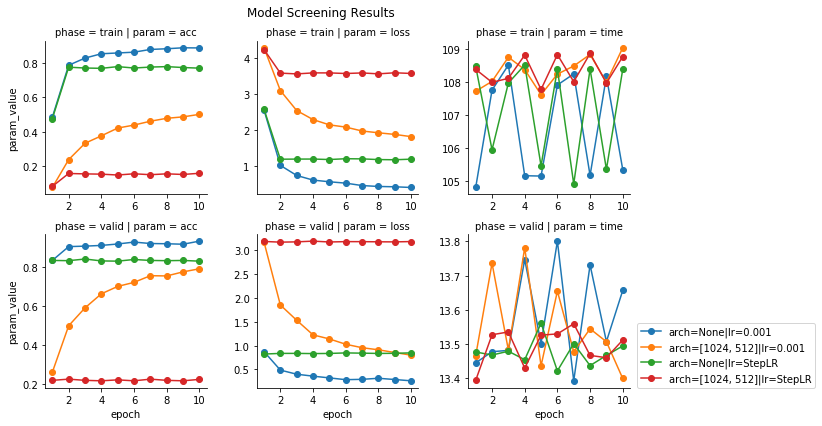

settings                                    \
                      model_id     model            modification   
19          arch=None|lr=0.001  resnet50             [2048, 102]   
11          arch=None|lr=0.001  resnet50             [2048, 102]   
13          arch=None|lr=0.001  resnet50             [2048, 102]   
15          arch=None|lr=0.001  resnet50             [2048, 102]   
9           arch=None|lr=0.001  resnet50             [2048, 102]   
17          arch=None|lr=0.001  resnet50             [2048, 102]   
7           arch=None|lr=0.001  resnet50             [2048, 102]   
5           arch=None|lr=0.001  resnet50             [2048, 102]   
3           arch=None|lr=0.001  resnet50             [2048, 102]   
45         arch=None|lr=StepLR  resnet50             [2048, 102]   
51         arch=None|lr=StepLR  resnet50             [2048, 102]   
1           arch=None|lr=0.001  resnet50             [2048, 102]   
41         arch=None|lr=StepLR  resnet50             [2048, 102]   
53         arch=None|lr=StepLR  resnet50             [2048, 102]   
57         arch=None|lr=StepLR  resnet50             [2048, 102]   
43         arch=None|lr=StepLR  resnet50             [2048, 102]   
55         arch=None|lr=StepLR  resnet50             [2048, 102]   
47         arch=None|lr=StepLR  resnet50             [2048, 102]   
49         arch=None|lr=StepLR  resnet50             [2048, 102]   
59         arch=None|lr=StepLR  resnet50             [2048, 102]   
39   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
37   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
33   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
35   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
31   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
29   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
27   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
25   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
23   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
21   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
..                         ...       ...                     ...   
54         arch=None|lr=StepLR  resnet50             [2048, 102]   
52         arch=None|lr=StepLR  resnet50             [2048, 102]   
42         arch=None|lr=StepLR  resnet50             [2048, 102]   
56         arch=None|lr=StepLR  resnet50             [2048, 102]   
44         arch=None|lr=StepLR  resnet50             [2048, 102]   
50         arch=None|lr=StepLR  resnet50             [2048, 102]   
58         arch=None|lr=StepLR  resnet50             [2048, 102]   
46         arch=None|lr=StepLR  resnet50             [2048, 102]   
38   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
36   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
0           arch=None|lr=0.001  resnet50             [2048, 102]   
34   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
40         arch=None|lr=StepLR  resnet50             [2048, 102]   
32   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
30   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
28   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
26   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
24   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
22   arch=[1024, 512]|lr=0.001  resnet50  [2048, 1024, 512, 102]   
78  arch=[1024, 512]|lr=StepLR  resnet50  [2048, 1024, 512, 102]   
62  arch=[1024, 512]|lr=StepLR  resnet50  [2048, 1024, 512, 102]   
70  arch=[1024, 512]|lr=StepLR  resnet50  [2048, 1024, 512, 102]   
74  arch=[1024, 512]|lr=StepLR  resnet50  [2048, 1024, 512, 102]   
64  arch=[1024, 512]|lr=StepLR  resnet50  [2048, 1024, 512, 102]   
66  arch=[1024, 512]|lr=StepLR  resnet50  [2048, 1024, 512, 102]   
76  arch=[1024, 512]|lr=StepLR  resnet50  [2048, 1024, 512, 102]   
72  arch=[

In [36]:
# PRINT TRAINING OVERVIEW
# stack results for easy printing    
stacked_results = pd.melt(results, id_vars=[*results['settings'].columns],
                          var_name='param', value_name='param_value', col_level=1)

# print results charts
g = sns.FacetGrid(stacked_results, col='param', row='phase', hue='model_id', 
                  sharex=True, sharey=False)
g.map(plt.plot, 'epoch', 'param_value', linestyle='-', marker='o')
plt.subplots_adjust(top=0.9)
plt.suptitle('Model Screening Results')
plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', borderaxespad=0);
plt.show()

# print results table sorted by validation accuracy
display(results.sort_values([('settings', 'phase'),('performance', 'acc')], axis=0, ascending=False))

#### Conculsions

Number of layers and learning rate play significant role in network learning. Model with classifier with none hidden layers is performing best, learns fastest with learning rate 0.001 and reached highest validation accuracy 93.3%. 

It seems that learning rate decay has not been designed well. It slows down learning and model with hidden layers [1024, 512] does not learn at all. Generaly models with hidden layers learns much slower than models with none hidden layers.

Drop out with probability of 50% seems to work well as there are no overfitting problems.

further steps to impove learning speed:
- redesing learning rate decay, increase learning rate interval for model with hidden layers ex: <0.003, 0.001>
- redesign learing rate decay, increase laerning rate interval for model with none hidden layers ex: <0.002, 0.0001>
- change architecture of hidden layers from [1024, 512] to [1024]

__Note__: I will not continue fine-tuning as already validation accuracy of best model is sufficient.



## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [58]:
def test_model(model, dataloader, batch_ratio=1):
    ''' 
    Evaluate accuracy of the model on test dataset
    
    Arg:
        model: neural network model nn.Module
        dataloader: dataloader for batching test dataset
        batch_ratio: iterates over bath_ratio % of batches in test dataset
    
    Acc: model accuracy
    '''
    
    # set model to evaluation mode
    model.eval()
    
    # initiate running correct classifications
    running_corrects = 0
    
    # initiate running number of samples
    running_size = 0
    # import ipdb; ipdb.set_trace()
    # iterate over n batches in test dataset
    num_batches = max(1, int(len(dataloader) * batch_ratio))
    for batch, (inputs, labels) in zip(range(num_batches), dataloader):   
        
        # update number of samples
        running_size += inputs.size(0)
        
        # transfer data to gpu if enabled
        inputs, labels = inputs.to(device), labels.to(device)
        
        # turn off gradient tracking to speed up prediction
        with torch.set_grad_enabled(False):    
            # calculate raw outputs
            outputs = model(inputs)
            
            # calculate top k prediction
            _, preds = outputs.topk(1, dim=1)
        
        # accumulate correct classifications
        running_corrects += torch.sum(preds == labels.view(preds.shape))

    # calculate accuracy of the model
    return (running_corrects.double() / running_size).item()

In [59]:
# MODEL VALIDATION on the test dataset
# load model
model, _, _, _, = load_model(path=path, mode='valid')

# test best model on x % of data
batch_ratio = batch_ratio    # x% of data

# move the networks to gpu if enabled
model.to(device)

# test model
print_model = 'model: {} ---> id: {}'.format(model.name, model.id)
print(print_model)
print('*' * len(print_model))
print('test acc: {:.4f}'
      .format(test_model(model, dataloaders[model.name]['test'], batch_ratio)))

model: resnet50 ---> id: arch=None|lr=0.001
*******************************************
test acc: 0.9219


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# Save the checkpoint 
# already done in tunning hyper-parameters of screened model section

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# Write a function that loads a checkpoint and rebuilds the model
# already done in tunning hyper-parameters of screened model section

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [60]:
def process_image(image_path, avgs=[0.485, 0.456, 0.406], stdevs=[0.229, 0.224, 0.225], 
                  resize=256, crop = 224):
    ''' 
    Scales (normalizes & standardizes), resize and crops a PIL image for a PyTorch model
        
    Args:
        image_path: path to image file including name
        resize: number of pixels of shorter size after image resizing
        avgs: array-like object - averages per each image channel to standardize to
        stdev: array-like object - standard deviations per each image channel to standardize to
        crop: crop size to center cropg
    
    Returns: 
        image: processed image as numpy array of shape (Channels, Width, Height)
    '''
    
    # Process a PIL image for use in a PyTorch model
    # open the image
    img_PIL = Image.open(image_path)

    # RESIZE IMAGE to keep shorter size 256pxl while keeping aspect ratio
    # get image size
    size = np.array(img_PIL.size)
    
    # calculate aspect ratio
    min_size, max_size = size.argmin(), size.argmax()
    asp_ratio = size[min_size] / size[max_size]
    
    # resize image
    size[min_size] = int(resize)
    size[max_size] = int(resize) / asp_ratio
    img_PIL = img_PIL.resize(tuple(size))
    
    # CENTER CROP IMAGE to size 224x224    
    # crop margins
    left = int((img_PIL.width - int(crop)) / 2)
    lower = int((img_PIL.height - int(crop)) / 2)
    right= left + int(crop)
    upper = lower + int(crop)
    
    # crop image
    img_PIL = img_PIL.crop((left, lower, right, upper))
    
    # SCALE IMAGE
    # normalize to range 0-1
    min_range = 0
    max_range = 255
    img = np.array(img_PIL)
    img = (img - min_range) / (max_range - min_range)
    
    # standardize
    img = (img - np.array(avgs)) / np.array(stdevs)
    
    # RESHAPE IMAGE
    # move channels to first dimension to complay with pytorch 
    img = img.transpose((2, 0, 1))
    
    return img

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [61]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    if title:
        plt.title(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

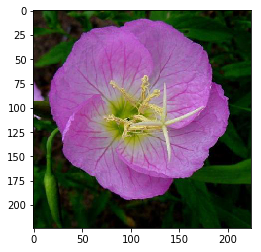

In [66]:
# test image processing
image_path = 'flowers/test/1/image_06764.jpg'
imshow(process_image(image_path));

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [95]:
def predict(image_path, model, topk=5):
    ''' 
    Predict the class (or classes) of an image using a trained deep learning model.
    
    Args:
        image_path: tensor image of shape (1, C, H, W) or path to the image which class need to be predicted
        model: neural network model of type nn.Module
        topk: number of top k predictions, integer
        
    Returns:
        top_pbs: list of top k probabilities
        top_cls: list of top k classes
        top_nms: list of top k classes names
    '''
    
    # IMAGE PROCESSING
    # scale, resize and crop image, return numpy array
    if isinstance(image_path, str): 
        img = process_image(image_path)

        # transform image to tensor of shape (batch_size, channel, width, height)
        img = (torch.from_numpy(img)      # create tensor from numpy
               .type(torch.FloatTensor)   # recast tensor to float dtype
               .unsqueeze(0))              # add 1 dimension left for batches
    else: 
        img = image_path

    # PREDICTION
    # set model to evaluation mode
    model.eval()
    
    # turn off gradient tracking to speed up prediction
    with torch.set_grad_enabled(False):
        # calculate raw outputs
        logits = model(img.to(device))
        
        # calculate probabilities
        pbs = nn.Softmax(dim=1)(logits)
        
        # select top k probabilities and classes indexes
        top_pbs, top_idx = pbs.topk(topk)
        
        # transform probabilities and classes idexes to list
        top_pbs = top_pbs.cpu().detach().numpy().tolist()[0]
        top_idx = top_idx.cpu().detach().numpy().tolist()[0]
    
    # RETURN probabilities, classes and classes names as list
    idx_to_class = dict(map(reversed, model.class_to_idx.items()))
    top_cls = [idx_to_class[idx] for idx in top_idx]
    top_nms = [class_to_name[top_cl] for top_cl in top_cls]
        
    return top_pbs, top_cls, top_nms    

In [141]:
# test predict function
predict(image_path, model)

([0.9663892984390259,
  0.027299558743834496,
  0.001492737210355699,
  0.0014003303367644548,
  0.0011252566473558545],
 ['1', '98', '19', '76', '51'],
 ['pink primrose',
  'mexican petunia',
  'balloon flower',
  'morning glory',
  'petunia'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [151]:
# Display an image along with the top k classes
def show_predict(image_path, model, topk=5):
    ''' 
   Print image with predicted class and bar chart with topk probabilities
    
    Args:
        image_path: tuple of (tensor img of shape (1, C, W, H), img label) or path to the image which class need to be predicted
        model: neural network model of type nn.Module
        topk: number of top k predictions, integer
    '''

    # process image
    if isinstance(image_path, str): 
        
        # predict top k probabilities, classes and classes names
        top_pbs, top_cls, top_nms = predict(image_path, model, topk=topk)
        img = process_image(image_path)
        img_class_num = image_path.split('/')[-2]
    else: 
        img, img_class_idx = image_path
        top_pbs, top_cls, top_nms = predict(img, model, topk=topk)
        class_idx_to_class_num = dict(map(reversed, model.class_to_idx.items()))
        img_class_num = class_idx_to_class_num[img_class_idx.item()]
        img = img.squeeze(0).detach().numpy()
        
    # set up figure to plot image and bar chart
    plt.figure(figsize=(11,3))
    
    # get image title
    img_class_name = class_to_name[img_class_num]
    
    # plot image
    imshow(img, ax=plt.subplot(1, 2, 1), title=img_class_name)
    
    # plot bar chart
    plt.subplot(1, 2, 2)
    sns.barplot(x=top_pbs, y=top_nms, color=sns.color_palette()[0])
    plt.title('Predicted Probabilities')
    
    # show plot
    plt.show()

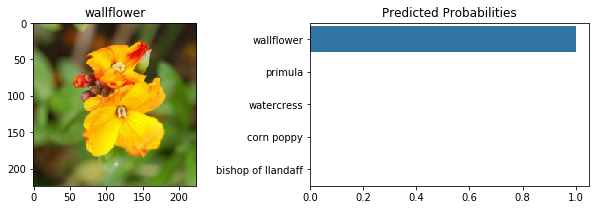

In [163]:
img, label = next(iter(dataloaders[model.name]['test']))
show_predict((img[0].unsqueeze(0), label[0]), model)